In [13]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [29]:
data = pd.read_json("C:/Indian_Number_plates.json",lines = True)
data.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [7]:
data['annotation'][0]

[{'label': ['number_plate'],
  'notes': '',
  'points': [{'x': 0.722084367245657, 'y': 0.5879828326180251},
   {'x': 0.8684863523573201, 'y': 0.688841201716738}],
  'imageWidth': 806,
  'imageHeight': 466}]

여기서 중요한 데이터로는 'points'와 'ImageWidth', 그리고 'ImageHeight'가 있다.

In [9]:
data['content'][0]

'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg'

이미지의 데이터가 url의 형태로 저장이 되어있기 때문에 이를 이용하기 위해서는 urllib으로 데이터를 불러와야 한다.

또한, 이미지 데이터가 저장이 되어있는 것이 아니기 때문에 디렉토리를 설정해서 이미지를 다운받는 과정을 거쳐야만 한다.

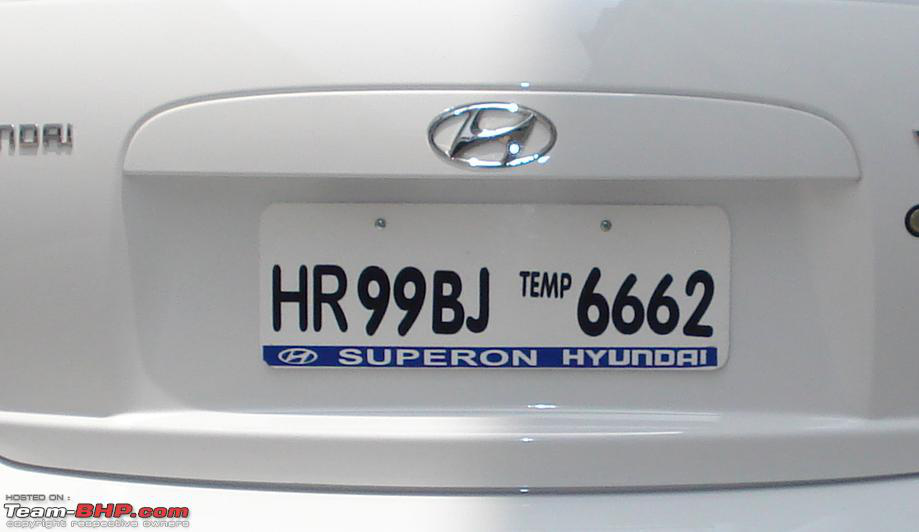

In [35]:
import urllib
img = urllib.request.urlopen(data["content"][19])
img = Image.open(img)
img

이 CNN학습의 목적은 글자를 추출해서 학습을 하는 것이 아니라 자동차 사진이 있을 때 자동차의 번호판 부분을 추출할 수 있는데에 목표를 둔다.
따라서 이미지 데이터에서 번호판 부분을 bounding 하기 위한 가로와 세로 축의 좌표의 범위를 y의 값, 즉 우리가 예측해야 하는 값으로 저장을 하고 학습후 예측을 하도록 하면 된다.

In [30]:
del data['extras']

url로 정보가 제공된 이미지를 저장하기 위해서 os.mkdir을 이용해서 저장 경로를 만들어주었다.

In [36]:
os.mkdir("C:/Indian Number Plates")

In [40]:
df = dict()
df['img_name'] = []
df['lowerx'], df['lowery'], df['upperx'], df['uppery'] = [],[],[],[]
df['width'], df['height'] = [],[]

for index, row in data.iterrows():
    img = urllib.request.urlopen(row['content'])
    img = Image.open(img).convert('RGB')
    img.save("C:/Indian Number Plates/licensed_car{}.jpeg".format(int(index)), "JPEG")
    
    df["img_name"].append("licensed_car{}".format(int(index)))
    
    now = row['annotation'][0]
    
    df['width'].append(now['imageWidth'])
    df['height'].append(now['imageHeight'])
    df['lowerx'].append(now['points'][0]['x'])
    df['lowery'].append(now['points'][0]['y'])
    df['upperx'].append(now['points'][1]['x'])
    df['uppery'].append(now['points'][1]['y'])

df라는 사전형 자료에 값들을 입력했으니 이를 dataframe의 형태로 바꿔주는 과정이 필요하다.

In [42]:
df = pd.DataFrame(df)

In [45]:
basic_dir = "C:/Indian Number Plates"
df['img_name'] = df['img_name'] + '.jpeg'
df.drop(['width', 'height'], axis = 1, inplace = True)

In [48]:
df.head()

,img_name,lowerx,lowery,upperx,uppery
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [114]:
x,y = [],[]
for index, row in df.iterrows():
    image = cv2.imread(os.path.join(basic_dir,row['img_name']), cv2.IMREAD_COLOR)/255
    x.append(cv2.resize(image, (224, 224)))
    y.append((row['lowerx'], row['lowery'], row['upperx'], row['uppery']))
    

In [116]:
x[0].shape

(224, 224, 3)

나중에 예측을 했을때 예측값이 어느정도 맞는지 확인하기 위해서 draw_bound라는 함수를 만들었다.

이 함수를 실행하게 되면 아래 사진과 같이 자동차 번호판에 직사각형 모양의 파란색 테두리가 그려지게 한다.

따라서 예측 결과가 시각화가 가능한 것이다.

In [117]:
width, height, resize = 224,224,128
def draw_bound(image,y):
    image = cv2.resize(image, dsize = (width, height))
    bx = int(y[0] * width)
    by = int(y[1] * height)
    tx = int(y[2] * width)
    ty = int(y[3] * height)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


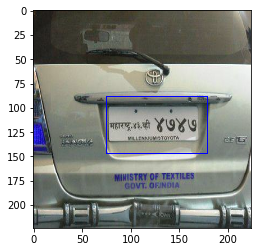

In [118]:
draw_bound(x[124], y[124])

imagenet을 이용한 모델중에 vgg16을 이용해서 새로운 특성을 추출하고자 한다.

그 전에 ImageDataGenerator을 만들어서 데이터를 조작하려고 한다.


In [121]:
np.array(x[0]).shape

(224, 224, 3)

In [122]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

In [124]:
from tensorflow.keras.applications.vgg16 import VGG16
model = tf.keras.models.Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260       
Total params: 17,938,756
Trainable params: 17,938,756
Non-trainable params: 0
__________________________________________

In [125]:
from tensorflow.keras.optimizers import Adam
adam_op = Adam(lr = 0.0001)
model.compile(optimizer = adam_op, loss = 'mse', metrics = ['accuracy'])

지금 사용하게 될 CNN Layer은 VGG16이라는 것인데, tf.keras.applications.VGG16()이다.

우선 모델안의 변수중 하나인 include_top = False가 아닌 이상 무조건 input_shape로 (224, 224, 3)의 모양의 RGB 이미지를 사용해야 한다.

이 레이어는 (Conv*2 + Pool)*5 + (Fully_Connected * 3 + Softmax) 로 구성이 되어 있으며, VGG19라는 비슷한 모델의 경우에는 (conv*3+Pool)인 층이 (Conv*2 + Pool)3개층 대신에 존재한다.

In [132]:
history = model.fit(np.array(x_train), np.array(y_train),validation_split = 0.2, epochs = 30)

Train on 170 samples, validate on 43 samples
Epoch 1/30
170/170 [==============================] - 128s 750ms/sample - loss: 0.0274 - accuracy: 0.5471 - val_loss: 0.0205 - val_accuracy: 0.4884
Epoch 2/30
170/170 [==============================] - 124s 728ms/sample - loss: 0.0158 - accuracy: 0.7353 - val_loss: 0.0129 - val_accuracy: 0.6744
Epoch 3/30
170/170 [==============================] - 124s 732ms/sample - loss: 0.0086 - accuracy: 0.8588 - val_loss: 0.0089 - val_accuracy: 0.7907
Epoch 4/30
170/170 [==============================] - 131s 772ms/sample - loss: 0.0051 - accuracy: 0.8294 - val_loss: 0.0063 - val_accuracy: 0.9070
Epoch 5/30
170/170 [==============================] - 139s 818ms/sample - loss: 0.0033 - accuracy: 0.9059 - val_loss: 0.0059 - val_accuracy: 0.8605
Epoch 6/30
170/170 [==============================] - 139s 817ms/sample - loss: 0.0023 - accuracy: 0.9412 - val_loss: 0.0057 - val_accuracy: 0.8605
Epoch 7/30
170/170 [==============================] - 138s 810ms/sa

In [134]:
model.evaluate(np.array(x_test), np.array(y_test))

24/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 3s 144ms/sample - loss: 0.0046 - accuracy: 0.7917


[0.004623317625373602, 0.7916667]

### Accuracy = 79.17%

In [136]:
y_pred = model.predict(np.array(x_test))

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i*3])
    plt.title(y[i*3])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


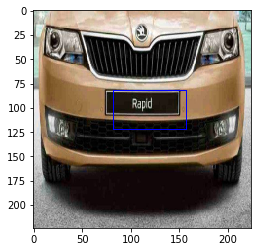

In [141]:
draw_bound(x_test[0], y_pred[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


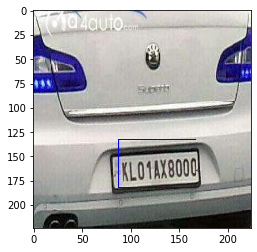

In [145]:
draw_bound(x_test[3], y_pred[3])

In [173]:
cv2.imread(np.array(x_test)[0], cv2.IMREAD_COLOR)

SystemError: <built-in function imread> returned NULL without setting an error

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


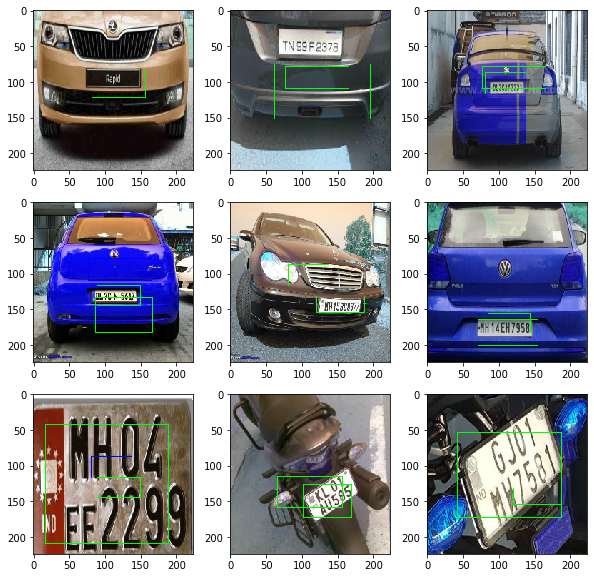

In [175]:
plt.figure(figsize=(10, 10))
for i in range(9):
    image = np.array(x_test)[i*2]
    ax = plt.subplot(3, 3, i + 1)
    y= y_pred[i*2]
    bx = int(y[0] * width)
    by = int(y[1] * height)
    tx = int(y[2] * width)
    ty = int(y[3] * height)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 255,0),1)
    plt.imshow(image)

위와 같이 초록색 부분이 예측한 부분이고, 이로 보아 CNN을 통해서 사진을 학습 시키게 되면 이 모델의 경우에는 정확도가 거의 80%에 육박하게 자동차의 숫자판을 인식할 수 있음을 알 수 있다.

조만간 OpenCV를 공부해서 실제로 사진에서의 텍스트 인식이라던가 다수가 있는 사진에서의 얼굴, 눈, 코, 입등 개별적인 인식을 하는 방법을 빨리 배우고 싶다. 그리고 나중에는 음성인식까지 할 수 있으면 좋겠다.

더불어서 matplotlib를 다루는 방법을 좀더 공부 해야 할 것 같다. 아직도 한 화면에 다수의 사진을 격자로 배치하는 것이 어렵기 때문이다.